In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import costcla as cc
from time import time
from copy import deepcopy
from scipy.optimize import fmin

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def get_error_rate(pred, Y):
    pos_mask = Y > 0
    neg_mask = Y < 0
    err_neg = sum(pred[neg_mask] != Y[neg_mask]) / float(sum(neg_mask))
    err_pos = sum(pred[pos_mask] != Y[pos_mask]) / float(sum(pos_mask))
    err_tot = sum(pred != Y) / float(len(Y)) 
    return err_tot, err_neg, err_pos

In [3]:
def cost_loss(y_true, y_pred, cost_mat):
    cost_N = (1 - y_true) * ((1 + y_pred) * cost_mat[:, 0] + (1 - y_pred) * cost_mat[:, 3]) / 4.0
    cost_P = (1 + y_true) * ((1 + y_pred) * cost_mat[:, 2] + (1 - y_pred) * cost_mat[:, 1]) / 4.0
    cost = cost_N + cost_P
    return [np.sum(cost), np.sum(cost_N), np.sum(cost_P)]

In [4]:
def savings_score(y_true, y_pred, cost_mat):
    n_samples = len(y_true)
    cost_base = min(cost_loss(y_true, np.ones(n_samples), cost_mat)[0],cost_loss(y_true, np.full(n_samples, -1.0), cost_mat)[0])
    cost = cost_loss(y_true, y_pred, cost_mat)[0]
    return 1.0 - cost / cost_base

In [5]:
def cost_confusion_matrix(y_true,y_pred,cost_mat):
    cost =  (1 - y_true) * ((1 + y_pred) * cost_mat[:, 0] + (1 - y_pred) * cost_mat[:, 3]) / 4.0
    cost += (1 + y_true) * ((1 + y_pred) * cost_mat[:, 2] + (1 - y_pred) * cost_mat[:, 1]) / 4.0
    TP,TN,FP,FN = 0.0,0.0,0.0,0.0
    for i in range(0,len(cost)):
        if y_pred[i] > 0:
            if y_true[i] > 0:
                TP += cost[i]
            else:
                FP += cost[i]
        else:
            if y_true[i] > 0:
                FN += cost[i]
            else:
                TN += cost[i]
    return np.array([[round(TN,3),round(FP,3)],[round(FN,3),round(TP,3)]])

In [6]:
def results(clf,X_train,y_train,cost_mat_train,X_test,y_test,cost_mat_test):
    pred_test  = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    print('       Cost Savings Cost_N Cost_P')
    cost, cost_N, cost_P = cost_loss(y_train, pred_train, cost_mat_train)
    print('train: %.2f %.3f %.2f %.2f' %(cost, savings_score(y_train,pred_train,cost_mat_train), cost_N, cost_P))
    cost, cost_N, cost_P = cost_loss(y_test, pred_test, cost_mat_test)
    print('test : %.2f %.3f %.2f %.2f' %(cost, savings_score(y_test,pred_test,cost_mat_test), cost_N, cost_P))
    print(confusion_matrix(y_test,pred_test))
    print(cost_confusion_matrix(y_test,pred_test,cost_mat_test )) # / cost_mat_test.max()

In [7]:
def plot_history(clf):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    df = pd.DataFrame()
    df['err_tot'] = clf.err_tot
    df['err_neg'] = clf.err_neg
    df['err_pos'] = clf.err_pos
    df['cost'] =    clf.costs
    df['cost_N'] =  clf.costs_N
    df['cost_P'] =  clf.costs_P
    df.err_tot.plot(legend = True, style='b', ax=axes[0])
    df.err_neg.plot(legend = True, style='r', ax=axes[0])
    df.err_pos.plot(legend = True, style='g', ax=axes[0])
    df.cost.plot(legend = True, style='b', ax=axes[1]) 
    df.cost_N.plot(legend = True, style='r', ax=axes[1])  
    df.cost_P.plot(legend = True, style='g', ax=axes[1]) 

In [8]:
class EDCS_AdaBoost():
    
    def __init__(self,base_estimator = None, n_estimators = 50, cost_func = 'CS1'):
        self.clf = base_estimator
        self.M = n_estimators
        self.clfs = []
        self.weights = []
        self.err_tot = []
        self.err_neg = []
        self.err_pos = []
        self.costs = []
        self.costs_N = []
        self.costs_P = []
        self.classes_ = [-1,1]
        if cost_func in ['CS1','CS2','CG1','CG2','C3']:
            self.cost_func = cost_func
        else:
            print("Available values of cost_func is 'CS1','CS2','CG1','CG2','C3'")
            sys.exit()
        
    def f2(self,beta,y,f,w,G):
        pos_mask = y > 0
        neg_mask = y < 0
        if self.cost_func == 'CG1':
            f1 = w * np.exp(-beta * y * G) * (1 + beta * G * self.D(y) / self.C(y,f))
        elif self.cost_func == 'CS1':
            f1 = w * np.exp(- beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
        elif self.cost_func == 'CG2':
            f1 = np.zeros(len(y))
            f1[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask]) * (1 + beta * G[pos_mask] * self.D_pos(y) / self.C_pos(y,f))
            f1[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask]) * (1 + beta * G[neg_mask] * self.D_neg(y) / self.C_neg(y,f))
        elif self.cost_func == 'CS2':
            f1 = np.zeros(len(y))
            f1[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask] * (self.C_pos(y,f) + self.D_pos(y) * (f[pos_mask] + beta * G[pos_mask])))
            f1[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask] * (self.C_neg(y,f) + self.D_neg(y) * (f[neg_mask] + beta * G[neg_mask])))
        elif self.cost_func == 'C3':
            f1 = w * (self.C(y,f) + beta * G * self.D(y)) * np.exp(- beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
        return f1.sum()
    
    def C(self,y,f):
        return ((1 + y) * ((1 + f) * self.C_TP + (1 - f) * self.C_FN) + (1 - y) * ((1 + f) * self.C_FP + (1 - f) * self.C_TN))/ 4.0
    
    def D(self,y):
        return ((1 + y) * (self.C_TP - self.C_FN) + (1 - y) * (self.C_FP - self.C_TN)) / 4.0
    
    def D_pos(self,y):
        pos_mask = y > 0
        return (self.C_TP[pos_mask] - self.C_FN[pos_mask]) / 2.0
    
    def D_neg(self,y):
        neg_mask = y < 0
        return (self.C_FP[neg_mask] - self.C_TN[neg_mask]) / 2.0
    
    def C_pos(self,y,f):
        pos_mask = y > 0
        return ((1 + f[pos_mask]) * self.C_TP[pos_mask] + (1 - f[pos_mask]) * self.C_FN[pos_mask]) / 2.0
    
    def C_neg(self,y,f):
        neg_mask = y < 0
        return ((1 + f[neg_mask]) * self.C_FP[neg_mask] + (1 - f[neg_mask]) * self.C_TN[neg_mask]) / 2.0
    
    def new_w(self,beta,y,G,w,f):
        pos_mask = y > 0
        neg_mask = y < 0
        if self.cost_func == 'CG1':
            w = w * np.exp(-beta * y * G) * (1 + beta * G * self.D(y) / self.C(y,f))
            w = w / sum(w)
        elif self.cost_func == 'CS1':
            w = w * np.exp(-beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
            w = w / sum(w)
        elif self.cost_func == 'CG2':
            w[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask]) * (1 + beta * G[pos_mask] * self.D_pos(y) / self.C_pos(y,f))
            w[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask]) * (1 + beta * G[neg_mask] * self.D_neg(y) / self.C_neg(y,f)) 
            w[pos_mask] = w[pos_mask]  / sum(w[pos_mask]) / 2 
            w[neg_mask] = w[neg_mask]  / sum(w[neg_mask]) / 2
        elif self.cost_func == 'CS2':
            w[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask] * (self.C_pos(y,f) + self.D_pos(y) * (f[pos_mask] + beta * G[pos_mask]))) 
            w[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask] * (self.C_neg(y,f) + self.D_neg(y) * (f[neg_mask] + beta * G[neg_mask]))) 
            w[pos_mask] = w[pos_mask]  / sum(w[pos_mask]) / 2 
            w[neg_mask] = w[neg_mask]  / sum(w[neg_mask]) / 2
        elif self.cost_func == 'C3':
            w = w * np.exp(-beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
            w = w / sum(w)
        return w
    
    def init_w(self,y):
        if self.cost_func == 'CS1' or self.cost_func == 'CG1' or self.cost_func == 'C3':
            return np.ones(len(y)) / len(y)
        elif self.cost_func == 'CS2' or self.cost_func == 'CG2':
            w = np.ones(len(y))
            pos_mask = y > 0
            neg_mask = y < 0
            w[pos_mask] = w[pos_mask] / sum(pos_mask) / 2
            w[neg_mask] = w[neg_mask] / sum(neg_mask) / 2
            return w
            
    def fit(self,X, y, cost_mat, verbose = False):
        cost_mat = cost_mat / cost_mat.max()
        self.C_FP = cost_mat[:,0] + 1.0
        self.C_FN = cost_mat[:,1] + 1.0
        self.C_TP = cost_mat[:,2] + 1.0
        self.C_TN = cost_mat[:,3] + 1.0
        
        ens = np.ones(len(y))      
        w = self.init_w(y)
        for i in range(self.M):
            f = ens
            self.clf.fit(X, y, sample_weight = np.array(w))     
            G = self.clf.predict(X)
            beta = fmin(self.f2,0.1,args = (y,f,w,G), disp = False)[0]  
            if beta < 0.001:
                if verbose:
                    print('Stop! beta=%.3f' %beta)
                self.M = np.argmin(np.array(self.costs)) + 1
                break    
            self.clfs.append(deepcopy(self.clf))
            self.weights.append(beta)
            ens = f + beta * G
            pred = np.sign(ens)
            err_tot, err_neg, err_pos = get_error_rate(pred, y)
            cost, cost_N, cost_P = cost_loss(y, pred, cost_mat)
            savings = savings_score(y,pred,cost_mat)
            self.err_tot.append(err_tot)
            self.err_neg.append(err_neg)
            self.err_pos.append(err_pos)
            self.costs.append(cost)
            self.costs_N.append(cost_N)
            self.costs_P.append(cost_P)
            if verbose:
                print('%2d %0.3f %0.3f %0.3f %6.2f %6.3f %6.3f' %(i,err_tot,err_neg,err_pos,beta,savings, cost))               
            w = self.new_w(beta,y,G,w,f)
            
    def predict(self,X):
        pred = np.ones(len(X))
        for i in range(self.M):
            pred = pred + self.weights[i] * self.clfs[i].predict(X)
        return np.sign(pred)
    
    def predict_proba(self,X):
        proba = sum(c.predict_proba(X) * w for c, w in zip(self.clfs,self.weights))
        proba /= sum(self.weights)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer
        return proba
    
    def fit_BMR(self, X, y):
        from costcla.models import BayesMinimumRiskClassifier
        y_0 = np.array([1 if y > 0 else 0 for y in y])
        self.bmr = BayesMinimumRiskClassifier()
        self.bmr.fit(y_0, self.predict_proba(X))
        
    def predict_BMR(self, X, cost_mat):
        y_pred_0 = self.bmr.predict(self.predict_proba(X), cost_mat)
        y_pred_1 = np.array([1 if y > 0 else -1 for y in y_pred_0])
        return y_pred_1

In [9]:
def calibrate(clf, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'sigmoid'):
    cal_clf = CalibratedClassifierCV(clf, cv="prefit", method=method)
    start = time()
    cal_clf.fit(X_train, y_train)
    end = time()
                
    C_FP, C_FN, C_TP, C_TN = cost_mat_train[:,0], cost_mat_train[:,1], cost_mat_train[:,2], cost_mat_train[:,3]
    p = cal_clf.predict_proba(X_train)[:,1]
    exp_cost_pos = (1 - p) * C_FP + p * C_TP
    exp_cost_neg = (1 - p) * C_TN + p * C_FN
    y_pred_train = np.array([* map(lambda ecp,ecn: 1 if ecp < ecn else 0, exp_cost_pos,exp_cost_neg)])
                
    C_FP, C_FN, C_TP, C_TN = cost_mat_test[:,0], cost_mat_test[:,1], cost_mat_test[:,2], cost_mat_test[:,3]
    p = cal_clf.predict_proba(X_test)[:,1]
    exp_cost_pos = (1 - p) * C_FP + p * C_TP
    exp_cost_neg = (1 - p) * C_TN + p * C_FN
    y_pred_test = np.array([* map(lambda ecp,ecn: 1 if ecp < ecn else 0, exp_cost_pos,exp_cost_neg)])
                
    return end-start, y_pred_train, y_pred_test          

In [10]:
def post_proc(label, t, y_train, y_train_pred, cost_mat_train, y_test, y_test_pred, cost_mat_test):
    
    y_train = np.array([1 if y > 0 else 0 for y in y_train])
    y_test  = np.array([1 if y > 0 else 0 for y in y_test])
    y_train_pred = np.array([1 if y > 0 else 0 for y in y_train_pred])
    y_test_pred  = np.array([1 if y > 0 else 0 for y in y_test_pred])
    
    savings_train = cc.metrics.savings_score(y_train,y_train_pred,cost_mat_train)
    savings_test = cc.metrics.savings_score(y_test,y_test_pred,cost_mat_test)
    f1_test = f1_score(y_test,y_test_pred)
    
    print('%8s: %6.1f %6.3f %6.3f %6.3F' %(label, t, savings_train, savings_test, f1_test))
    
    res.append([label,t, savings_train, savings_test, f1_test]) 

In [11]:
def test_classifiers(datasets, 
                     my_algorithms, costcla_algorithms, costcla_labels, sk_algorithms, sk_labels,
                     my_BMR = False, costcla_BMR = False, sk_BMR = False,
                     my_Platt = False, costcla_Platt = False, sk_Platt = False,
                     my_Iso = False, costcla_Iso = False, sk_Iso = False):
 
    dt = DecisionTreeClassifier(max_depth = 1)

    print('Clf        Time  Train  Test      F1')
    for data in datasets:
        print(data['label'],'================================')
        X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
                        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)
        y_train_1 = np.array([1 if y > 0 else -1 for y in y_train])
        y_test_1  = np.array([1 if y > 0 else -1 for y in y_test])

        for cost in my_algorithms:
            edab = EDCS_AdaBoost(base_estimator = dt, n_estimators = 100, cost_func = cost)
            start = time()
            edab.fit(X_train, y_train_1, cost_mat_train, verbose = False)
            end = time()
            
            post_proc(cost, end-start, y_train_1, edab.predict(X_train), cost_mat_train, y_test_1, edab.predict(X_test), cost_mat_test)         

            if my_BMR:
                start = time()
                edab.fit_BMR(X_train, y_train_1)
                end = time()
                
                post_proc(cost+'-BMR', end-start, y_train_1, edab.predict_BMR(X_train,cost_mat_train), cost_mat_train, 
                                                  y_test_1, edab.predict_BMR(X_test,cost_mat_test), cost_mat_test)
            
            if my_Platt:
                t, y_pred_train, y_pred_test = calibrate(edab, X_train, y_train_1, cost_mat_train, X_test, y_test_1, cost_mat_test, method = 'sigmoid')
                
                post_proc(cost+'-Pla', end-start, y_train, y_pred_train, cost_mat_train, y_test, y_pred_test, cost_mat_test)

       
            if my_Iso:
                t, y_pred_train, y_pred_test = calibrate(edab, X_train, y_train_1, cost_mat_train, X_test, y_test_1, cost_mat_test, method = 'isotonic')

                post_proc(cost+'-Iso', end-start, y_train, y_pred_train, cost_mat_train, y_test, y_pred_test, cost_mat_test)


        for i,cc_alg in enumerate(costcla_algorithms):
            start = time()
            cc_alg.fit(X_train, y_train, cost_mat_train)
            end = time()
            
            post_proc(costcla_labels[i], end-start, y_train, cc_alg.predict(X_train), cost_mat_train, y_test, cc_alg.predict(X_test), cost_mat_test) 

            if costcla_BMR:
                cc_bmr = cc.models.BayesMinimumRiskClassifier()
                start = time()
                cc_bmr.fit(y_train, cc_alg.predict_proba(X_train))
                end = time()
                
                post_proc(costcla_labels[i]+'-BMR', end-start, y_train, cc_bmr.predict(cc_alg.predict_proba(X_train),cost_mat_train), cost_mat_train, 
                                                               y_test,  cc_bmr.predict(cc_alg.predict_proba(X_test),cost_mat_test), cost_mat_test)
              
            if costcla_Platt:
                t, y_pred_train, y_pred_test = calibrate(cc_alg, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'sigmoid')

                post_proc(costcla_labels[i]+'-Pla', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)
            
            if costcla_Iso:
                t, y_pred_train, y_pred_test = calibrate(cc_alg, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'isotonic')
                
                post_proc(costcla_labels[i]+'-Iso', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)

        
        for i, clf in enumerate(sk_algorithms):
            start =time()
            clf.fit(X_train,y_train)
            end = time()
            
            post_proc(sk_labels[i], end-start, y_train, clf.predict(X_train), cost_mat_train, y_test,  clf.predict(X_test), cost_mat_test)

            if sk_BMR:
                clf_bmr = cc.models.BayesMinimumRiskClassifier()
                start = time()
                clf_bmr.fit(y_train, clf.predict_proba(X_train))
                end = time()
                
                post_proc(sk_labels[i]+'-BMR', end-start, y_train, clf_bmr.predict(clf.predict_proba(X_train),cost_mat_train), cost_mat_train, 
                                                          y_test,  clf_bmr.predict(clf.predict_proba(X_test),cost_mat_test), cost_mat_test)

                
            if sk_Platt:
                t, y_pred_train, y_pred_test = calibrate(clf, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'sigmoid')

                post_proc(sk_labels[i]+'-Pla', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)
                
            
            if sk_Iso:
                t, y_pred_train, y_pred_test = calibrate(cc_alg, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'isotonic')

                post_proc(sk_labels[i]+'-Iso', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)

#### Testing costcla datasets

In [12]:
from costcla.datasets import load_bankmarketing, load_creditscoring1, load_creditscoring2

data_b = load_bankmarketing()
data_cs1 = load_creditscoring1()
data_cs2 = load_creditscoring2()

In [13]:
data_b.cost_mat[0:5]

array([[ 1.        , 13.19730655,  1.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.        ],
       [ 1.        ,  9.27444874,  1.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.        ]])

In [14]:
costcla_datasets = []
for l,d in zip(['bank'],[data_b]):  #[,'cs1','cs2'] , [,data_cs1,data_cs2]
    costcla_datasets.append({'label' : l, 'X' : d.data, 'y' : d.target, 'cost_mat' : d.cost_mat})
    print(l,d.data.shape,d.target.shape,d.cost_mat.shape)
    
#cm = costcla_datasets[2]['cost_mat']
#cm_mask = cm[:,0] > 0
#costcla_datasets[2]['X'] = costcla_datasets[2]['X'][cm_mask]
#costcla_datasets[2]['y'] = costcla_datasets[2]['y'][cm_mask]
#costcla_datasets[2]['cost_mat'] = costcla_datasets[2]['cost_mat'][cm_mask]

#for d in costcla_datasets:
#    print(d['label'],d['X'].shape,d['y'].shape,d['cost_mat'].shape)

bank (37931, 32) (37931,) (37931, 4)


In [15]:
res = []

In [16]:
my_algorithms = ['CS1','CG1','C3'] # 'CS2','CG2'

costcla_algorithms = [cc.models.CostSensitiveDecisionTreeClassifier(),
                      cc.models.CostSensitiveRandomPatchesClassifier(n_estimators=25, combination='weighted_voting')]
costcla_labels = ['CSDT','CSRP']

sk_algorithms = [AdaBoostClassifier()]
sk_labels = ['AB']

test_classifiers(costcla_datasets,
                 my_algorithms, costcla_algorithms, costcla_labels, sk_algorithms, sk_labels,
                 my_BMR = True, costcla_BMR = True, sk_BMR = True,
                 my_Platt = True, costcla_Platt = True, sk_Platt = True,
                 my_Iso = True, costcla_Iso = True, sk_Iso = True)

Clf        Time  Train  Test      F1
bank ================================
     CS1:   39.3  0.265  0.298  0.343
 CS1-BMR:    0.4  0.502  0.498  0.298
 CS1-Pla:    0.4  0.483  0.486  0.277
 CS1-Iso:    0.4  0.502  0.498  0.298
     CG1:   40.1  0.263  0.301  0.345
 CG1-BMR:    0.4  0.503  0.497  0.297
 CG1-Pla:    0.4  0.484  0.487  0.277
 CG1-Iso:    0.4  0.503  0.497  0.297
      C3:   24.3  0.265  0.304  0.347
  C3-BMR:    0.3  0.501  0.500  0.299
  C3-Pla:    0.3  0.484  0.487  0.277
  C3-Iso:    0.3  0.501  0.500  0.299
    CSDT:    7.2  0.477  0.471  0.266
CSDT-BMR:    0.0  0.476  0.472  0.267
CSDT-Pla:    0.0  0.476  0.471  0.267
CSDT-Iso:    0.0  0.476  0.472  0.267
    CSRP:   52.0  0.474  0.468  0.260
CSRP-BMR:    0.6  0.488  0.484  0.277
CSRP-Pla:    0.6  0.479  0.470  0.267
CSRP-Iso:    0.6  0.488  0.484  0.277
      AB:    1.7 -0.256 -0.354  0.258
  AB-BMR:    0.6  0.501  0.498  0.298
  AB-Pla:    0.6  0.498  0.497  0.294
  AB-Iso:    0.6  0.488  0.484  0.277


#### Toys Datasets

In [17]:
def asymmetry(y, cost_mat):
    C_FP, C_FN, C_TP, C_TN = cost_mat[:,0],cost_mat[:,1],cost_mat[:,2],cost_mat[:,3]
    C_neg = (C_FN - C_TN) / (C_FP - C_TN)
    C_pos = (C_TP - C_TN) / (C_FP - C_TN)
    b = C_neg - C_pos
    
    Pos = sum(y[y == 1])       #Number of positive training examples
    Neg = len(y) - Pos
    skew = C_FP * Neg / (C_FN * Pos + C_FP * Neg)  

    return np.mean(b), np.std(b), np.mean(skew)

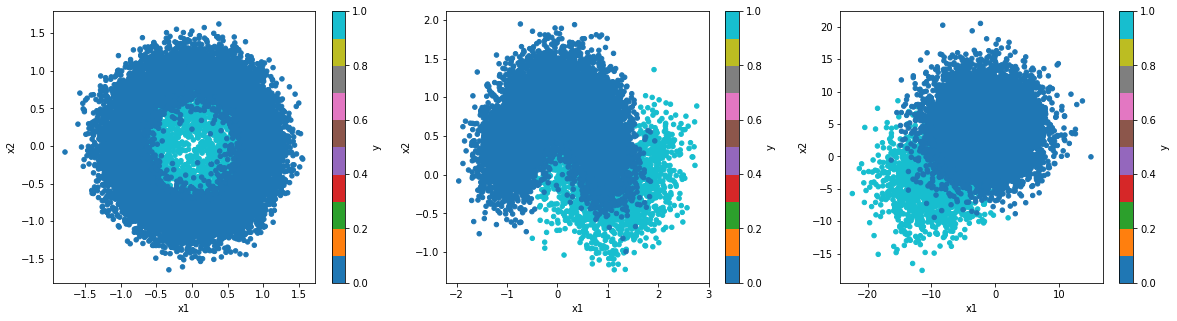

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

ds_labels = ['circles','moons','blobs']

toy_datasets = []

for i,label in enumerate(ds_labels):
    df = pd.read_csv(label+'.csv')
    toy_datasets.append({'label' : label, 'X' : df[['x1','x2']].values, 'y' : df.y.values, 'cost_mat' : df[['C_FP','C_FN','C_TP','C_TN']].values})
    df.plot.scatter(x = 'x1', y='x2', c ='y', colormap='tab10', ax=axes[i])

In [19]:
my_algorithms = ['CS1','CG1'] # 'CS2','CG2', 'C3'

costcla_algorithms = [cc.models.CostSensitiveDecisionTreeClassifier(),
                      cc.models.CostSensitiveRandomPatchesClassifier(n_estimators=25, combination='weighted_voting')]
costcla_labels = ['CSDT','CSRP']

sk_algorithms = [AdaBoostClassifier()]
sk_labels = ['AB']

test_classifiers(toy_datasets, 
                 my_algorithms, costcla_algorithms, costcla_labels, sk_algorithms, sk_labels,
                 my_BMR = True, costcla_BMR = True, sk_BMR = True,
                 my_Platt = True, costcla_Platt = True, sk_Platt = True,
                 my_Iso = True, costcla_Iso = True, sk_Iso = True)

Clf        Time  Train  Test      F1
circles ================================
     CS1:   14.2  0.621  0.593  0.609
 CS1-BMR:    0.1  0.639  0.586  0.557
 CS1-Pla:    0.1  0.613  0.558  0.558
 CS1-Iso:    0.1  0.639  0.586  0.557
     CG1:   15.7  0.597  0.557  0.590
 CG1-BMR:    0.1  0.644  0.582  0.554
 CG1-Pla:    0.1  0.611  0.548  0.557
 CG1-Iso:    0.1  0.644  0.582  0.554


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    CSDT:    0.4  0.000  0.000  0.000
CSDT-BMR:    0.0 -0.606 -0.712  0.208
CSDT-Pla:    0.0 -0.606 -0.712  0.208
CSDT-Iso:    0.0 -0.606 -0.712  0.208


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    CSRP:    3.0  0.000  0.000  0.000
CSRP-BMR:    0.0 -0.606 -0.712  0.208
CSRP-Pla:    0.0 -0.606 -0.712  0.208
CSRP-Iso:    0.0 -0.606 -0.712  0.208
      AB:    0.3  0.440  0.436  0.714
  AB-BMR:    0.1  0.657  0.582  0.565
  AB-Pla:    0.1  0.646  0.596  0.568
  AB-Iso:    0.1 -0.606 -0.712  0.208
moons ================================
     CS1:    3.6  0.901  0.907  0.659
 CS1-BMR:    0.0  0.904  0.912  0.611
 CS1-Pla:    0.0  0.906  0.914  0.604
 CS1-Iso:    0.0  0.904  0.912  0.611
     CG1:    7.8  0.911  0.925  0.748
 CG1-BMR:    0.0  0.922  0.932  0.680
 CG1-Pla:    0.0  0.910  0.916  0.617
 CG1-Iso:    0.0  0.922  0.932  0.680
    CSDT:    1.6  0.800  0.792  0.560
CSDT-BMR:    0.0  0.798  0.795  0.497
CSDT-Pla:    0.0  0.795  0.793  0.487
CSDT-Iso:    0.0  0.798  0.795  0.497
    CSRP:   10.9  0.683  0.664  0.449
CSRP-BMR:    0.0  0.753  0.746  0.436
CSRP-Pla:    0.0  0.712  0.728  0.415
CSRP-Iso:    0.0  0.753  0.746  0.436
      AB:    0.3  0.803  0.784  0.739
  AB-BMR:  

#### Insurance dataset

In [20]:
ds_labels = ['alpha']

ins_datasets = []

for label in ds_labels:
    df = pd.read_csv(label+'.csv')
    ins_datasets.append({'label' : label, 'X' : df.drop(['No','C_FP','C_FN','C_TP','C_TN','y'],axis = 1).values, 'y' : df.y.values, 'cost_mat' : df[['C_FP','C_FN','C_TP','C_TN']].values})

In [21]:
my_algorithms = ['CS1','CG1','C3'] # 'CS2','CG2',

costcla_algorithms = [cc.models.CostSensitiveDecisionTreeClassifier(),
                      cc.models.CostSensitiveRandomPatchesClassifier(n_estimators=25, combination='weighted_voting')]
costcla_labels = ['CSDT','CSRP']

sk_algorithms = [AdaBoostClassifier()]
sk_labels = ['AB']

test_classifiers(ins_datasets, 
                 my_algorithms, costcla_algorithms, costcla_labels, sk_algorithms, sk_labels,
                 my_BMR = True, costcla_BMR = True, sk_BMR = True,
                 my_Platt = True, costcla_Platt = True, sk_Platt = True,
                 my_Iso = True, costcla_Iso = True, sk_Iso = True)

Clf        Time  Train  Test      F1
alpha ================================
     CS1:    1.1  0.130  0.184  0.252
 CS1-BMR:    0.0  0.180  0.179  0.262
 CS1-Pla:    0.0  0.117  0.173  0.262
 CS1-Iso:    0.0  0.180  0.179  0.262
     CG1:    2.3  0.207  0.079  0.267
 CG1-BMR:    0.0  0.246  0.141  0.255
 CG1-Pla:    0.0  0.122  0.160  0.260
 CG1-Iso:    0.0  0.246  0.141  0.255
      C3:    1.0  0.130  0.184  0.252
  C3-BMR:    0.0  0.180  0.179  0.262
  C3-Pla:    0.0  0.117  0.172  0.261
  C3-Iso:    0.0  0.180  0.179  0.262
    CSDT:   28.1  0.240  0.162  0.259
CSDT-BMR:    0.0  0.236  0.162  0.257
CSDT-Pla:    0.0  0.228  0.166  0.257
CSDT-Iso:    0.0  0.236  0.162  0.257
    CSRP:  198.1  0.210  0.197  0.272
CSRP-BMR:    0.1  0.258  0.178  0.251
CSRP-Pla:    0.1  0.242  0.158  0.258
CSRP-Iso:    0.1  0.258  0.178  0.251
      AB:    0.5  0.039  0.014  0.045
  AB-BMR:    0.2  0.327  0.130  0.281
  AB-Pla:    0.2  0.315  0.133  0.278
  AB-Iso:    0.2  0.258  0.178  0.251


### Post processing

In [22]:
df_res = pd.DataFrame(res, columns = ['Clf','Time','Train','Test','F1'])

In [23]:
df_res.shape

(108, 5)

In [24]:
ds = []
for i in range(0,24):
    ds.append('bank')
for i in range(24,44):
    ds.append('circles')
for i in range(44,64):
    ds.append('moons')
for i in range(64,84):
    ds.append('blobs')
for i in range(84,108):
    ds.append('alpha')
df_res['Dataset'] = ds

In [25]:
# df_res.to_csv('results.csv',sep = ';', decimal = ',')

In [26]:
for data in toy_datasets:
    b_mean, b_var, skew = asymmetry(data['y'],data['cost_mat'])
    print('%7s %6.3f  %6.2f %6.3f' %(data['label'],b_mean, b_var, skew))
    print(len(data['y']), len(data['y'][data['y'] > 0])/ len(data['y']), data['X'].shape)
for data in ins_datasets:
    b_mean, b_var, skew = asymmetry(data['y'],data['cost_mat'])
    print('%7s %6.3f  %6.2f %6.3f' %(data['label'],b_mean, b_var, skew))
    print(len(data['y']), len(data['y'][data['y'] > 0])/ len(data['y']), data['X'].shape)
for data in costcla_datasets:
    b_mean, b_var, skew = asymmetry(data['y'],data['cost_mat'])
    print('%7s %6.3f  %6.2f %6.3f' %(data['label'],b_mean, b_var, skew))
    print(len(data['y']), len(data['y'][data['y'] > 0])/ len(data['y']), data['X'].shape)

circles 10.886  161.51  0.420
11499 0.13035916166623185 (11499, 2)
  moons 12.933  253.07  0.426
11464 0.12770411723656663 (11464, 2)
  blobs 12.394  197.32  0.413
11522 0.13209512237458776 (11522, 2)
  alpha  6.248    1.67  0.630
8400 0.08785714285714286 (8400, 31)
   bank  9.306   19.90  0.590
37931 0.12620284200258364 (37931, 32)


#### AdaMEC

In [27]:
def skew(cost_mat):
    C_FP, C_FN, C_TP, C_TN = cost_mat[:,0],cost_mat[:,1],cost_mat[:,2],cost_mat[:,3]
    return C_FP / (C_FN + C_FP)

data = ins_datasets[0]

X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
                        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)

uncalAB = AdaBoostClassifier(algorithm="SAMME.R")

start = time()
uncalAB.fit(X_train, y_train)
end = time()

post_proc('uncal AB', end-start, y_train, uncalAB.predict(X_train),cost_mat_train, 
                           y_test,  uncalAB.predict(X_test), cost_mat_test)

calAB = CalibratedClassifierCV(uncalAB, cv="prefit", method="sigmoid")
start = time()
calAB.fit(X_train, y_train)
end = time()

post_proc('cal AB', end-start, y_train, calAB.predict(X_train),cost_mat_train, 
                               y_test,  calAB.predict(X_test), cost_mat_test)

y_pred_train = np.sign(calAB.predict_proba(X_train)[:,1] - skew(cost_mat_train))
y_pred_test  = np.sign(calAB.predict_proba(X_test)[:,1] - skew(cost_mat_test))

post_proc('cal AB', end-start, y_train, y_pred_train, cost_mat_train, 
                               y_test,  y_pred_test,  cost_mat_test)

uncal AB:    0.5  0.039  0.014  0.045
  cal AB:    0.1  0.039  0.014  0.045
  cal AB:    0.1  0.315  0.133  0.278


#### Analysis - Moon dataset

In [28]:
data = toy_datasets[1]

X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)
y_train_1 = np.array([1 if y > 0 else -1 for y in y_train])
y_test_1  = np.array([1 if y > 0 else -1 for y in y_test])

edab_CG1 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'CG1')
edab_CG1.fit(X_train, y_train_1, cost_mat_train, verbose = False)

results(edab_CG1,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

       Cost Savings Cost_N Cost_P
train: 22.47 0.911 8.93 13.54
test : 9.34 0.925 4.50 4.84
[[3098  219]
 [  57  410]]
[[0.    4.496]
 [4.844 0.   ]]


In [29]:
edab_CS1 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'CS1')
edab_CS1.fit(X_train, y_train_1, cost_mat_train, verbose = False)
results(edab_CS1,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

       Cost Savings Cost_N Cost_P
train: 24.83 0.901 14.73 10.09
test : 11.67 0.907 7.79 3.89
[[2917  400]
 [  41  426]]
[[0.    7.789]
 [3.886 0.   ]]


In [30]:
edab_C3 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'C3')
edab_C3.fit(X_train, y_train_1, cost_mat_train, verbose = False)
results(edab_C3,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

       Cost Savings Cost_N Cost_P
train: 24.13 0.904 7.01 17.12
test : 10.98 0.912 3.78 7.20
[[3195  122]
 [ 131  336]]
[[0.    3.778]
 [7.2   0.   ]]


In [31]:
edab_CG1.fit_BMR(X_train, y_train_1)

pred_test  = edab_CG1.predict_BMR(X_test,cost_mat_test)
pred_train = edab_CG1.predict_BMR(X_train,cost_mat_train)
    
print('       Cost Savings Cost_N Cost_P')
cost, cost_N, cost_P = cost_loss(y_train_1, pred_train, cost_mat_train)
print('train: %.2f %.3f %.2f %.2f' %(cost, savings_score(y_train_1,pred_train,cost_mat_train), cost_N, cost_P))
cost, cost_N, cost_P = cost_loss(y_test_1, pred_test, cost_mat_test)
print('test : %.2f %.3f %.2f %.2f' %(cost, savings_score(y_test_1,pred_test,cost_mat_test), cost_N, cost_P))
print(confusion_matrix(y_test_1,pred_test))
print(cost_confusion_matrix(y_test_1,pred_test,cost_mat_test))

       Cost Savings Cost_N Cost_P
train: 19.61 0.922 9.17 10.44
test : 8.53 0.932 4.32 4.22
[[2964  353]
 [  45  422]]
[[0.    4.316]
 [4.219 0.   ]]


In [32]:
d = {'y' : y_test_1, 'C1' : edab_CS1.predict(X_test), 'C2' : edab_CG1.predict(X_test), 
     'C3' : edab_C3.predict(X_test), 'C2_ROC' : edab_CG1.predict_BMR(X_test,cost_mat_test),
     'C_FP' : cost_mat_test[:,0], 'C_FN' : cost_mat_test[:,1], 'C_TP' : cost_mat_test[:,2], 'C_TN' : cost_mat_test[:,3]}
df_an = pd.DataFrame(d)

In [33]:
c_max = df_an.C_FN.max()
print('Total', df_an.shape[0], 'examples, c_max =', c_max)
n =11

c_left = 0
k_tot = 0
fig = []

for i in range(0,n-1):
    c_right = c_left + c_max / n
    df_sub = df_an[df_an.C_FN >= c_left][df_an.C_FN < c_right]
    k = df_sub.shape[0]
    k_tot += k
    err_C1 = sum(df_sub.C1 != df_sub.y) / k
    err_C2 = sum(df_sub.C2 != df_sub.y) / k
    err_C3 = sum(df_sub.C3 != df_sub.y) / k
    err_C2_ROC = sum(df_sub.C2_ROC != df_sub.y) / k
    
    cm = df_sub[['C_FP','C_FN','C_TP','C_TN']].values
    
    cost_C1, neg_C1, pos_C1 = cost_loss(df_sub.y, df_sub.C1, cm)
    cost_C2, neg_C2, pos_C2 = cost_loss(df_sub.y, df_sub.C2, cm)
    cost_C3, neg_C3, pos_C3 = cost_loss(df_sub.y, df_sub.C3, cm)
    cost_C2_ROC, neg_C2_ROC, pos_C2_ROC = cost_loss(df_sub.y, df_sub.C2_ROC, cm)
    
    tot_cost = df_sub.C_FN.sum()
    fig.append([k, round(c_left,3), round((c_left+c_right)/2,3), round(c_right,3),
                err_C1,  err_C2,  err_C3,  err_C2_ROC, tot_cost,
                cost_C1, cost_C2, cost_C3, cost_C2_ROC,
                neg_C1,  neg_C2,  neg_C3,  neg_C2_ROC,
                pos_C1,  pos_C2,  pos_C3,  pos_C2_ROC])
    
    c_left = c_right

df_fig = pd.DataFrame(fig, columns = ['No_of_ex','C_FN_left','mean(C_FN)','C_FN_right',
                                      'EDAB.C1','EDAB.C2','EDAB.C3','EDAB.C2-ROC', 'tot_cost',
                                      'loss.C1','loss.C2','loss.C3','loss.C2-ROC',
                                      'neg.C1','neg.C2','neg.C3','neg.C2-ROC',
                                      'pos.C1','pos.C2','pos.C3','pos.C2-ROC'])
df_fig.head(10)

Total 3784 examples, c_max = 1.5040549707899658


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,No_of_ex,C_FN_left,mean(C_FN),C_FN_right,EDAB.C1,EDAB.C2,EDAB.C3,EDAB.C2-ROC,tot_cost,loss.C1,...,loss.C3,loss.C2-ROC,neg.C1,neg.C2,neg.C3,neg.C2-ROC,pos.C1,pos.C2,pos.C3,pos.C2-ROC
0,1113,0.000,0.068,0.137,0.237197,0.159030,0.153639,0.193172,71.473872,4.282396,...,5.639529,3.397364,1.995048,1.051167,0.507530,1.088928,2.287348,2.776393,5.131999,2.308435
1,948,0.137,0.205,0.273,0.138186,0.065401,0.045359,0.105485,194.013423,3.890313,...,1.816338,2.113909,3.309214,1.448744,1.077810,1.532810,0.581099,0.738528,0.738528,0.581099
2,710,0.273,0.342,0.410,0.036620,0.026761,0.026761,0.053521,239.625542,1.219815,...,1.239197,1.189527,0.839405,0.547641,0.547641,0.497971,0.380409,0.691556,0.691556,0.691556
3,468,0.410,0.479,0.547,0.014957,0.014957,0.014957,0.049145,221.417475,0.427730,...,0.427730,0.274120,0.427730,0.427730,0.427730,0.274120,0.000000,0.000000,0.000000,0.000000
4,255,0.547,0.615,0.684,0.007843,0.007843,0.007843,0.027451,154.412739,0.735296,...,0.735296,0.660432,0.097705,0.097705,0.097705,0.022841,0.637591,0.637591,0.637591,0.637591
5,138,0.684,0.752,0.820,0.028986,0.028986,0.028986,0.036232,102.755716,0.435889,...,0.435889,0.386855,0.435889,0.435889,0.435889,0.386855,0.000000,0.000000,0.000000,0.000000
6,82,0.820,0.889,0.957,0.048780,0.048780,0.048780,0.060976,72.193495,0.392324,...,0.392324,0.376766,0.392324,0.392324,0.392324,0.376766,0.000000,0.000000,0.000000,0.000000
7,42,0.957,1.025,1.094,0.023810,0.023810,0.023810,0.071429,42.600723,0.094767,...,0.094767,-0.060601,0.094767,0.094767,0.094767,-0.060601,0.000000,0.000000,0.000000,0.000000
8,17,1.094,1.162,1.231,0.058824,0.000000,0.058824,0.058824,19.768209,0.012037,...,0.012037,0.012037,0.012037,0.000000,0.012037,0.012037,0.000000,0.000000,0.000000,0.000000
9,8,1.231,1.299,1.367,0.125000,0.000000,0.125000,0.125000,10.225190,0.184415,...,0.184415,0.184415,0.184415,0.000000,0.184415,0.184415,0.000000,0.000000,0.000000,0.000000


In [34]:
print(df_fig[['No_of_ex','loss.C1','loss.C2','loss.C3','loss.C2-ROC']].sum())
df_fig.set_index('mean(C_FN)', inplace = True)

No_of_ex       3781.000000
loss.C1          11.674984
loss.C2           9.340036
loss.C3          10.977524
loss.C2-ROC       8.534824
dtype: float64


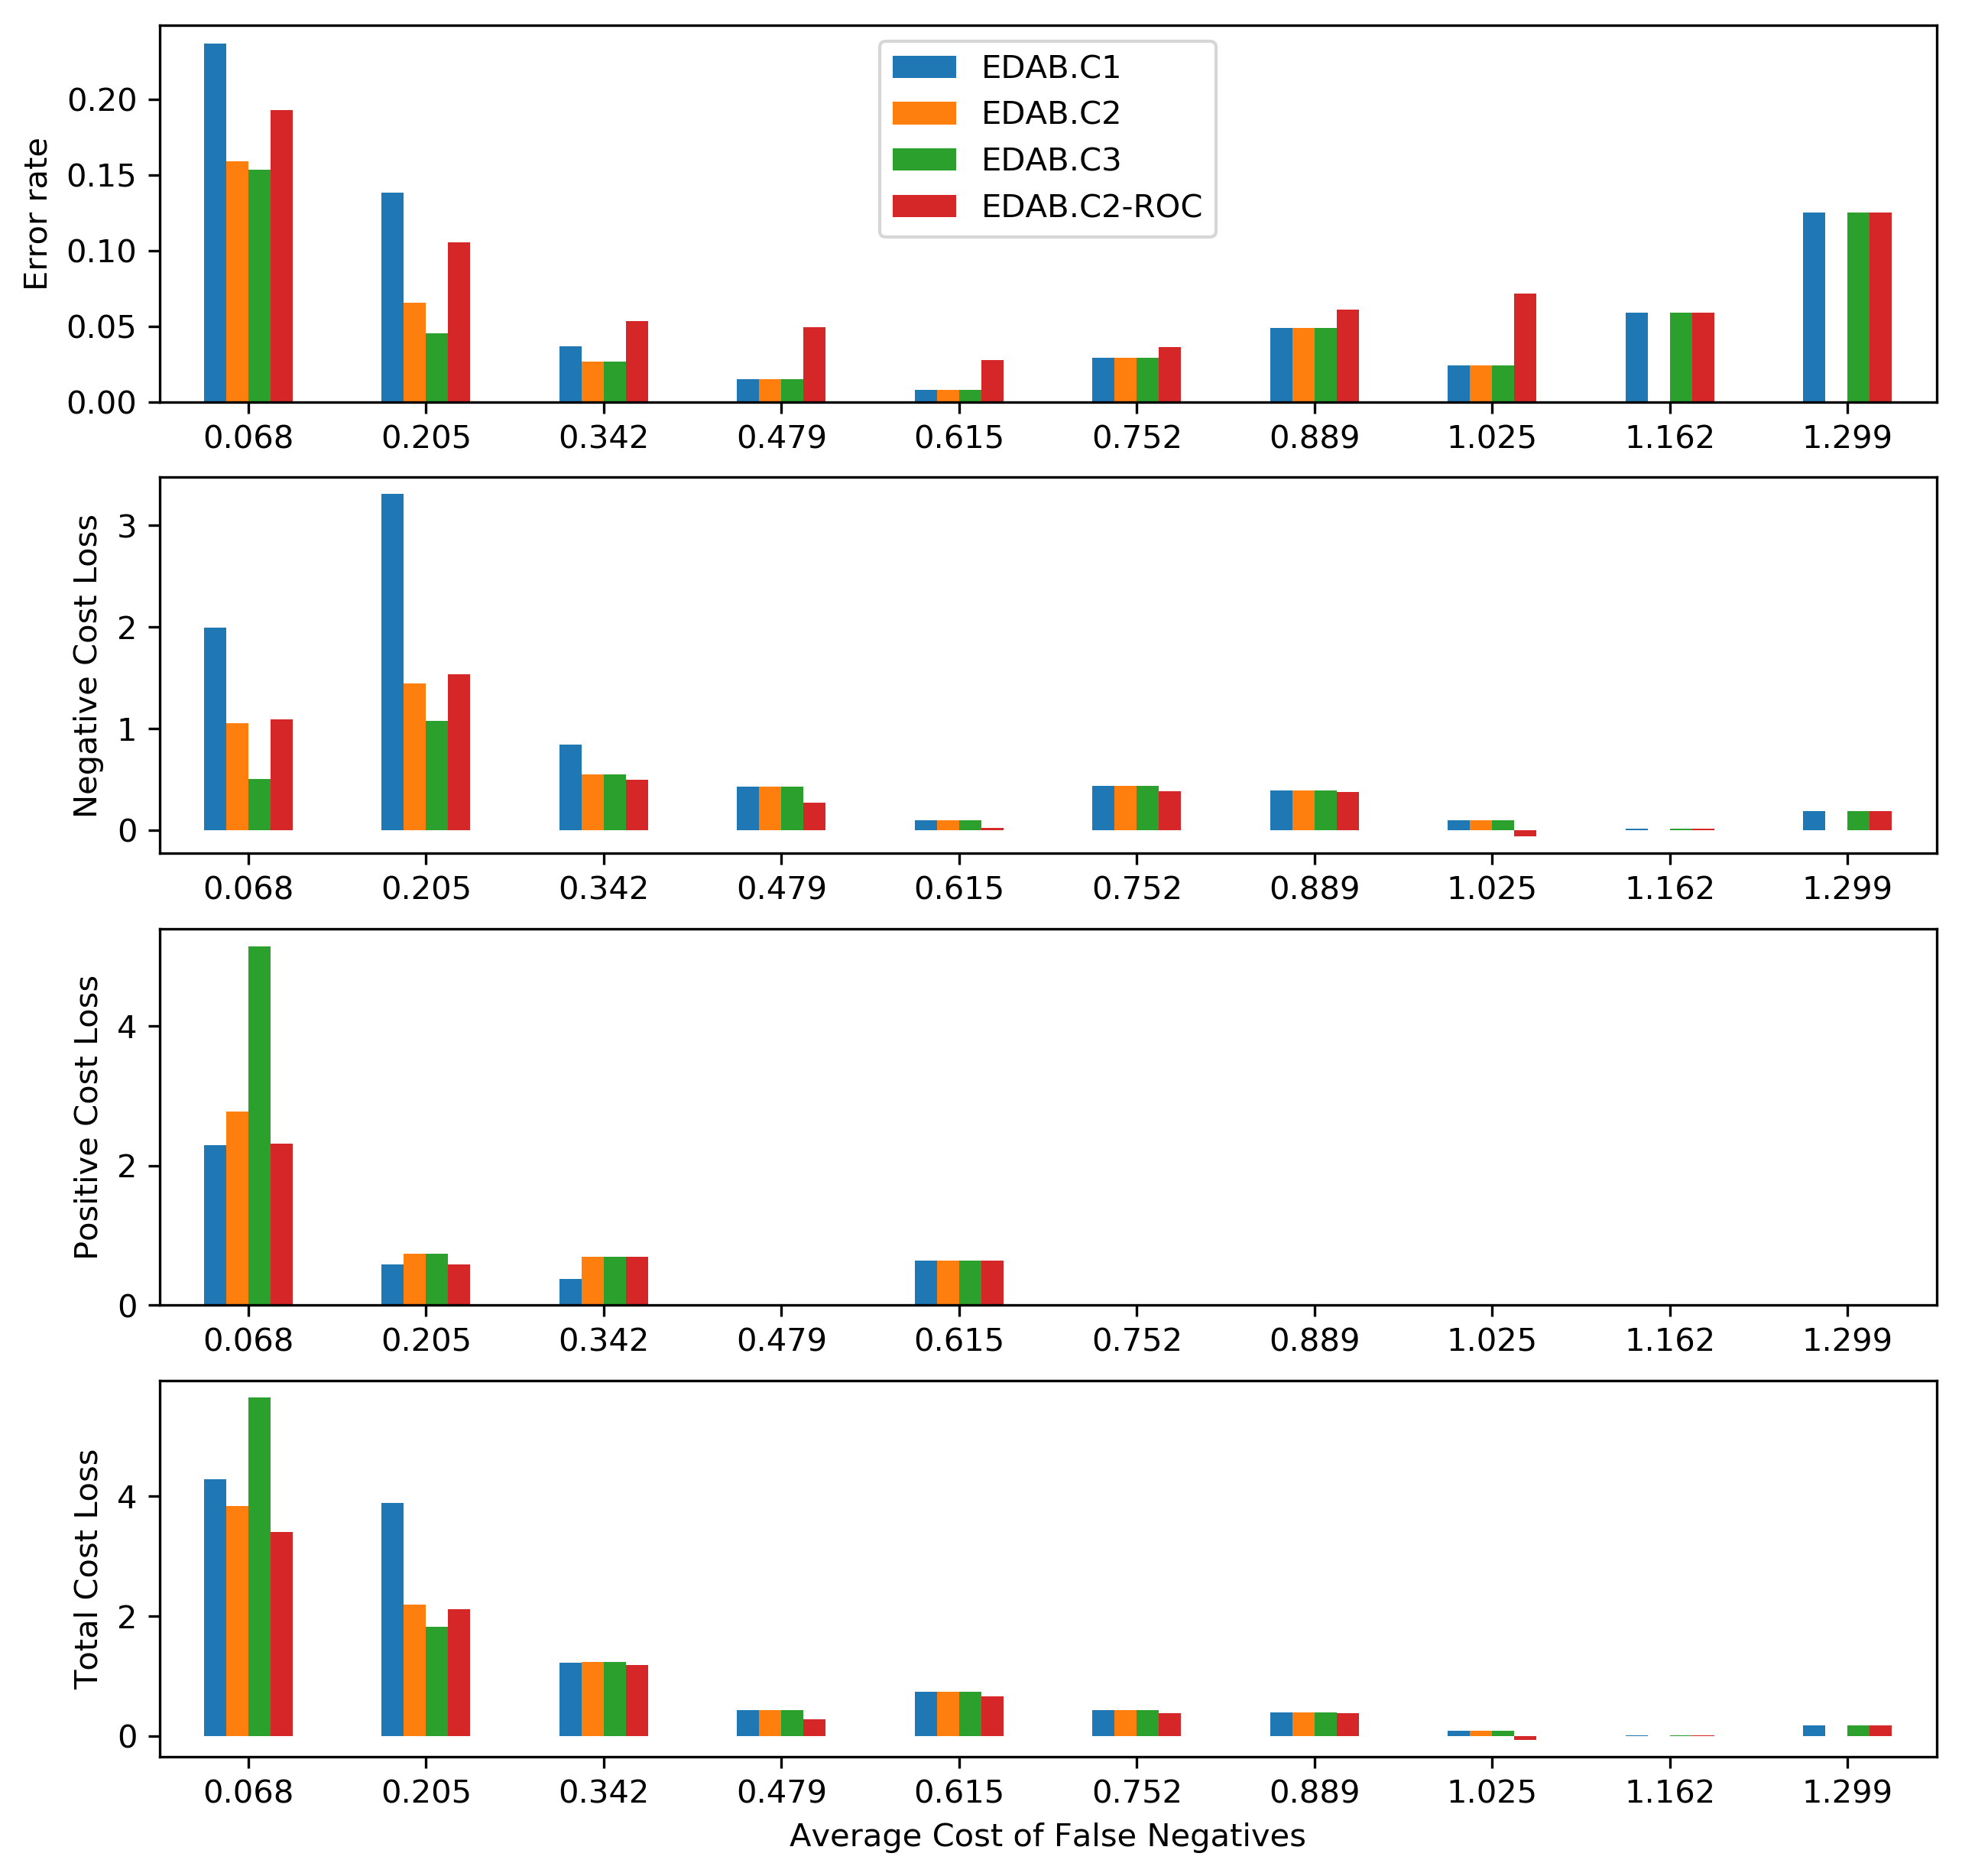

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize = (10,10), dpi = 300)

df_fig[['EDAB.C1','EDAB.C2','EDAB.C3', 'EDAB.C2-ROC']].plot.bar(rot = 0, ax=axes[0])
axes[0].set(ylabel = 'Error rate', xlabel = ' ')

df_fig[['neg.C1','neg.C2','neg.C3', 'neg.C2-ROC']].plot.bar(rot = 0, ax=axes[1], legend = False)
axes[1].set(ylabel = 'Negative Cost Loss', xlabel = ' ')

df_fig[['pos.C1','pos.C2','pos.C3', 'pos.C2-ROC']].plot.bar(rot = 0, ax=axes[2], legend = False)
axes[2].set(ylabel = 'Positive Cost Loss', xlabel = ' ')

df_fig[['loss.C1','loss.C2','loss.C3', 'loss.C2-ROC']].plot.bar(rot = 0, ax=axes[3], legend = False)
axes[3].set(ylabel = 'Total Cost Loss', xlabel = 'Average Cost of False Negatives')

plt.savefig('Fig1.png', dpi=300)

#### Analysis - Ins Dataset

EDAB.C1 ---------
       Cost Savings Cost_N Cost_P
train: 179966.50 0.130 21220.07 158746.43
test : 77319.15 0.184 12154.81 65164.34
[[2356  177]
 [ 179   60]]
[[    0.    12154.811]
 [65164.337     0.   ]]
EDAB.C2 ---------
       Cost Savings Cost_N Cost_P
train: 164045.11 0.207 86054.56 77990.56
test : 87241.84 0.079 45155.40 42086.44
[[1856  677]
 [  98  141]]
[[    0.    45155.401]
 [42086.443     0.   ]]
EDAB.C3 ----------
       Cost Savings Cost_N Cost_P
train: 179966.50 0.130 21220.07 158746.43
test : 77319.15 0.184 12154.81 65164.34
[[2356  177]
 [ 179   60]]
[[    0.    12154.811]
 [65164.337     0.   ]]
EDAB.C2-ROC -------
       Cost Savings Cost_N Cost_P
train: 155996.67 0.246 61722.39 94274.28
test : 81393.11 0.141 30845.73 50547.38
[[2039  494]
 [ 132  107]]
[[    0.    30845.728]
 [50547.38      0.   ]]

Total 2772 examples, c_max = 2009.3922358242728


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


No_of_ex        2770.000000
loss.C1        77319.148347
loss.C2        87081.745728
loss.C3        77319.148347
loss.C2-ROC    81233.009593
dtype: float64


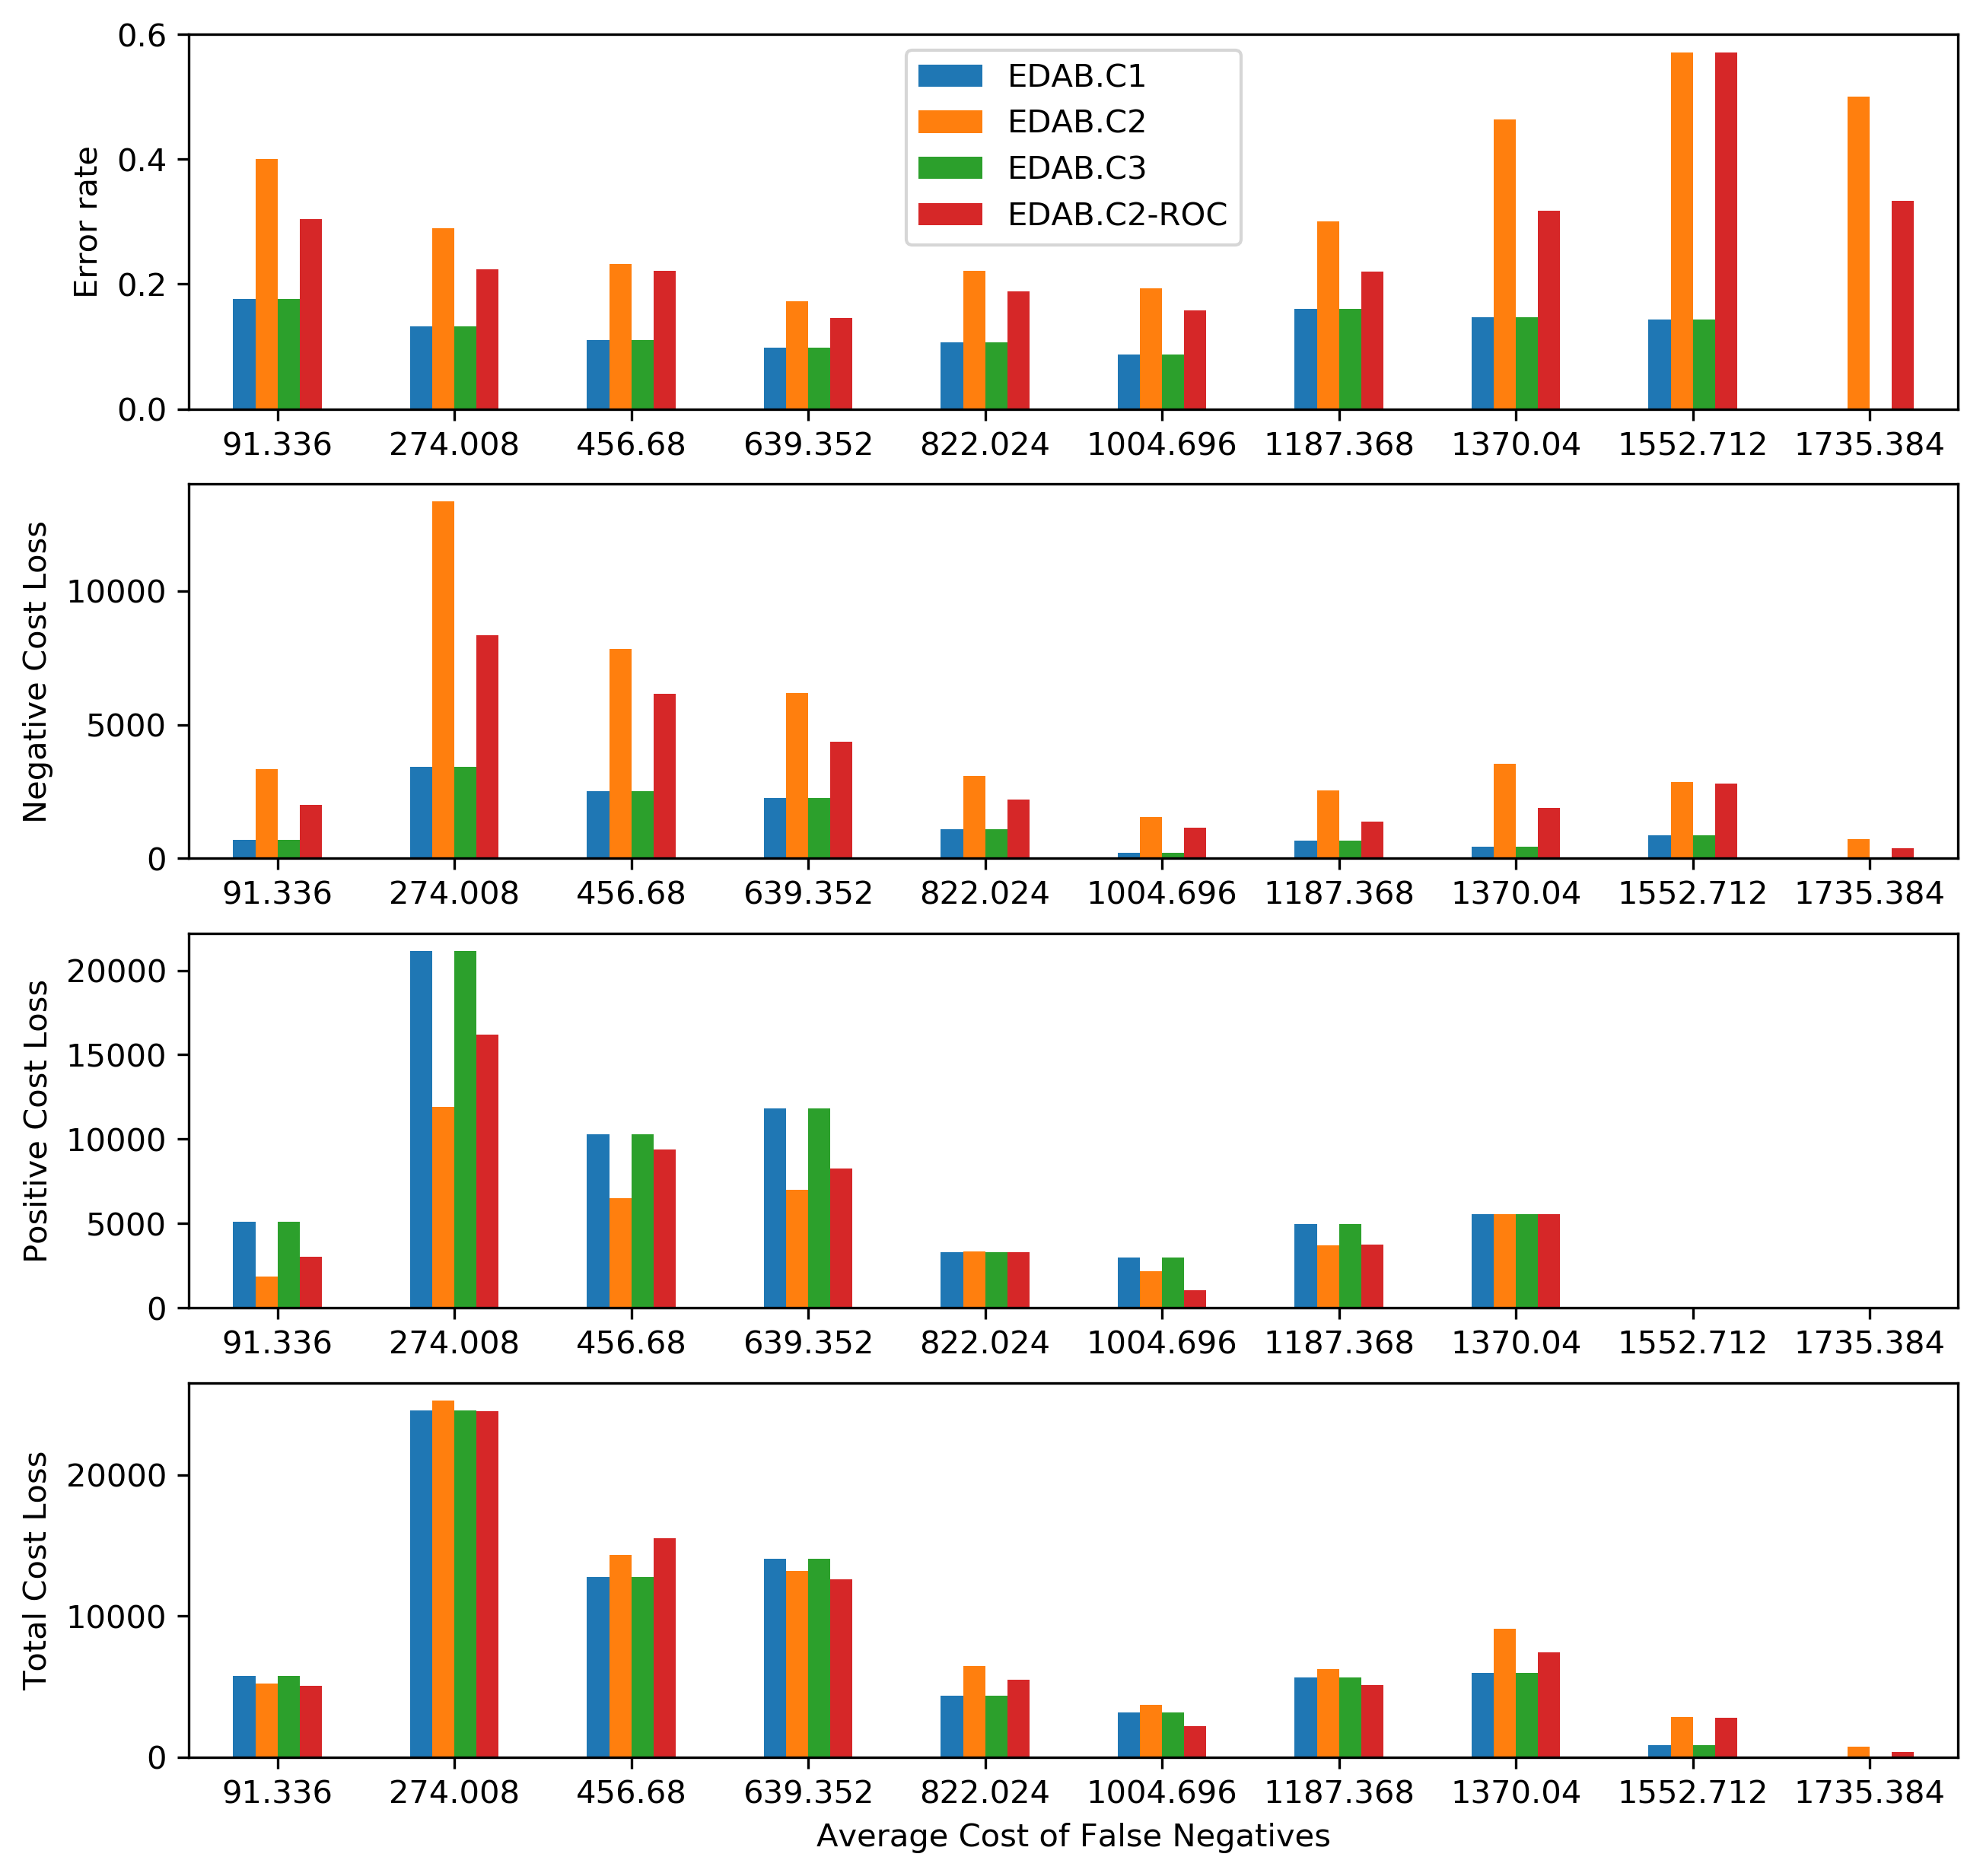

In [40]:
data = ins_datasets[0]

X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)
y_train_1 = np.array([1 if y > 0 else -1 for y in y_train])
y_test_1  = np.array([1 if y > 0 else -1 for y in y_test])


edab_CS1 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'CS1')
edab_CS1.fit(X_train, y_train_1, cost_mat_train, verbose = False)
print('EDAB.C1 ---------')
results(edab_CS1,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

edab_CG1 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'CG1')
edab_CG1.fit(X_train, y_train_1, cost_mat_train, verbose = False)
print('EDAB.C2 ---------')
results(edab_CG1,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

edab_C3 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'C3')
edab_C3.fit(X_train, y_train_1, cost_mat_train, verbose = False)
print('EDAB.C3 ----------')
results(edab_C3,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

edab_CG1.fit_BMR(X_train, y_train_1)

pred_test  = edab_CG1.predict_BMR(X_test,cost_mat_test)
pred_train = edab_CG1.predict_BMR(X_train,cost_mat_train)
print('EDAB.C2-ROC -------')   
print('       Cost Savings Cost_N Cost_P')
cost, cost_N, cost_P = cost_loss(y_train_1, pred_train, cost_mat_train)
print('train: %.2f %.3f %.2f %.2f' %(cost, savings_score(y_train_1,pred_train,cost_mat_train), cost_N, cost_P))
cost, cost_N, cost_P = cost_loss(y_test_1, pred_test, cost_mat_test)
print('test : %.2f %.3f %.2f %.2f' %(cost, savings_score(y_test_1,pred_test,cost_mat_test), cost_N, cost_P))
print(confusion_matrix(y_test_1,pred_test))
print(cost_confusion_matrix(y_test_1,pred_test,cost_mat_test))


d = {'y' : y_test_1, 'C1' : edab_CS1.predict(X_test), 'C2' : edab_CG1.predict(X_test), 
     'C3' : edab_C3.predict(X_test), 'C2_ROC' : edab_CG1.predict_BMR(X_test,cost_mat_test),
     'C_FP' : cost_mat_test[:,0], 'C_FN' : cost_mat_test[:,1], 'C_TP' : cost_mat_test[:,2], 'C_TN' : cost_mat_test[:,3]}
df_an = pd.DataFrame(d)

c_max = df_an.C_FN.max()
print()
print('Total', df_an.shape[0], 'examples, c_max =', c_max)
n =11

c_left = 0
k_tot = 0
fig = []

for i in range(0,n-1):
    c_right = c_left + c_max / n
    df_sub = df_an[df_an.C_FN >= c_left][df_an.C_FN < c_right]
    k = df_sub.shape[0]
    k_tot += k
    err_C1 = sum(df_sub.C1 != df_sub.y) / k
    err_C2 = sum(df_sub.C2 != df_sub.y) / k
    err_C3 = sum(df_sub.C3 != df_sub.y) / k
    err_C2_ROC = sum(df_sub.C2_ROC != df_sub.y) / k
    
    cm = df_sub[['C_FP','C_FN','C_TP','C_TN']].values
    
    cost_C1, neg_C1, pos_C1 = cost_loss(df_sub.y, df_sub.C1, cm)
    cost_C2, neg_C2, pos_C2 = cost_loss(df_sub.y, df_sub.C2, cm)
    cost_C3, neg_C3, pos_C3 = cost_loss(df_sub.y, df_sub.C3, cm)
    cost_C2_ROC, neg_C2_ROC, pos_C2_ROC = cost_loss(df_sub.y, df_sub.C2_ROC, cm)
    
    tot_cost = df_sub.C_FN.sum()
    fig.append([k, round(c_left,3), round((c_left+c_right)/2,3), round(c_right,3),
                err_C1,  err_C2,  err_C3,  err_C2_ROC, tot_cost,
                cost_C1, cost_C2, cost_C3, cost_C2_ROC,
                neg_C1,  neg_C2,  neg_C3,  neg_C2_ROC,
                pos_C1,  pos_C2,  pos_C3,  pos_C2_ROC])
    
    c_left = c_right

df_fig = pd.DataFrame(fig, columns = ['No_of_ex','C_FN_left','mean(C_FN)','C_FN_right',
                                      'EDAB.C1','EDAB.C2','EDAB.C3','EDAB.C2-ROC', 'tot_cost',
                                      'loss.C1','loss.C2','loss.C3','loss.C2-ROC',
                                      'neg.C1','neg.C2','neg.C3','neg.C2-ROC',
                                      'pos.C1','pos.C2','pos.C3','pos.C2-ROC'])

print(df_fig[['No_of_ex','loss.C1','loss.C2','loss.C3','loss.C2-ROC']].sum())
df_fig.set_index('mean(C_FN)', inplace = True)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize = (10,10), dpi = 300)

df_fig[['EDAB.C1','EDAB.C2','EDAB.C3', 'EDAB.C2-ROC']].plot.bar(rot = 0, ax=axes[0])
axes[0].set(ylabel = 'Error rate', xlabel = ' ')

df_fig[['neg.C1','neg.C2','neg.C3', 'neg.C2-ROC']].plot.bar(rot = 0, ax=axes[1], legend = False)
axes[1].set(ylabel = 'Negative Cost Loss', xlabel = ' ')

df_fig[['pos.C1','pos.C2','pos.C3', 'pos.C2-ROC']].plot.bar(rot = 0, ax=axes[2], legend = False)
axes[2].set(ylabel = 'Positive Cost Loss', xlabel = ' ')

df_fig[['loss.C1','loss.C2','loss.C3', 'loss.C2-ROC']].plot.bar(rot = 0, ax=axes[3], legend = False)
axes[3].set(ylabel = 'Total Cost Loss', xlabel = 'Average Cost of False Negatives')

plt.savefig('Fig2.png', dpi=300)

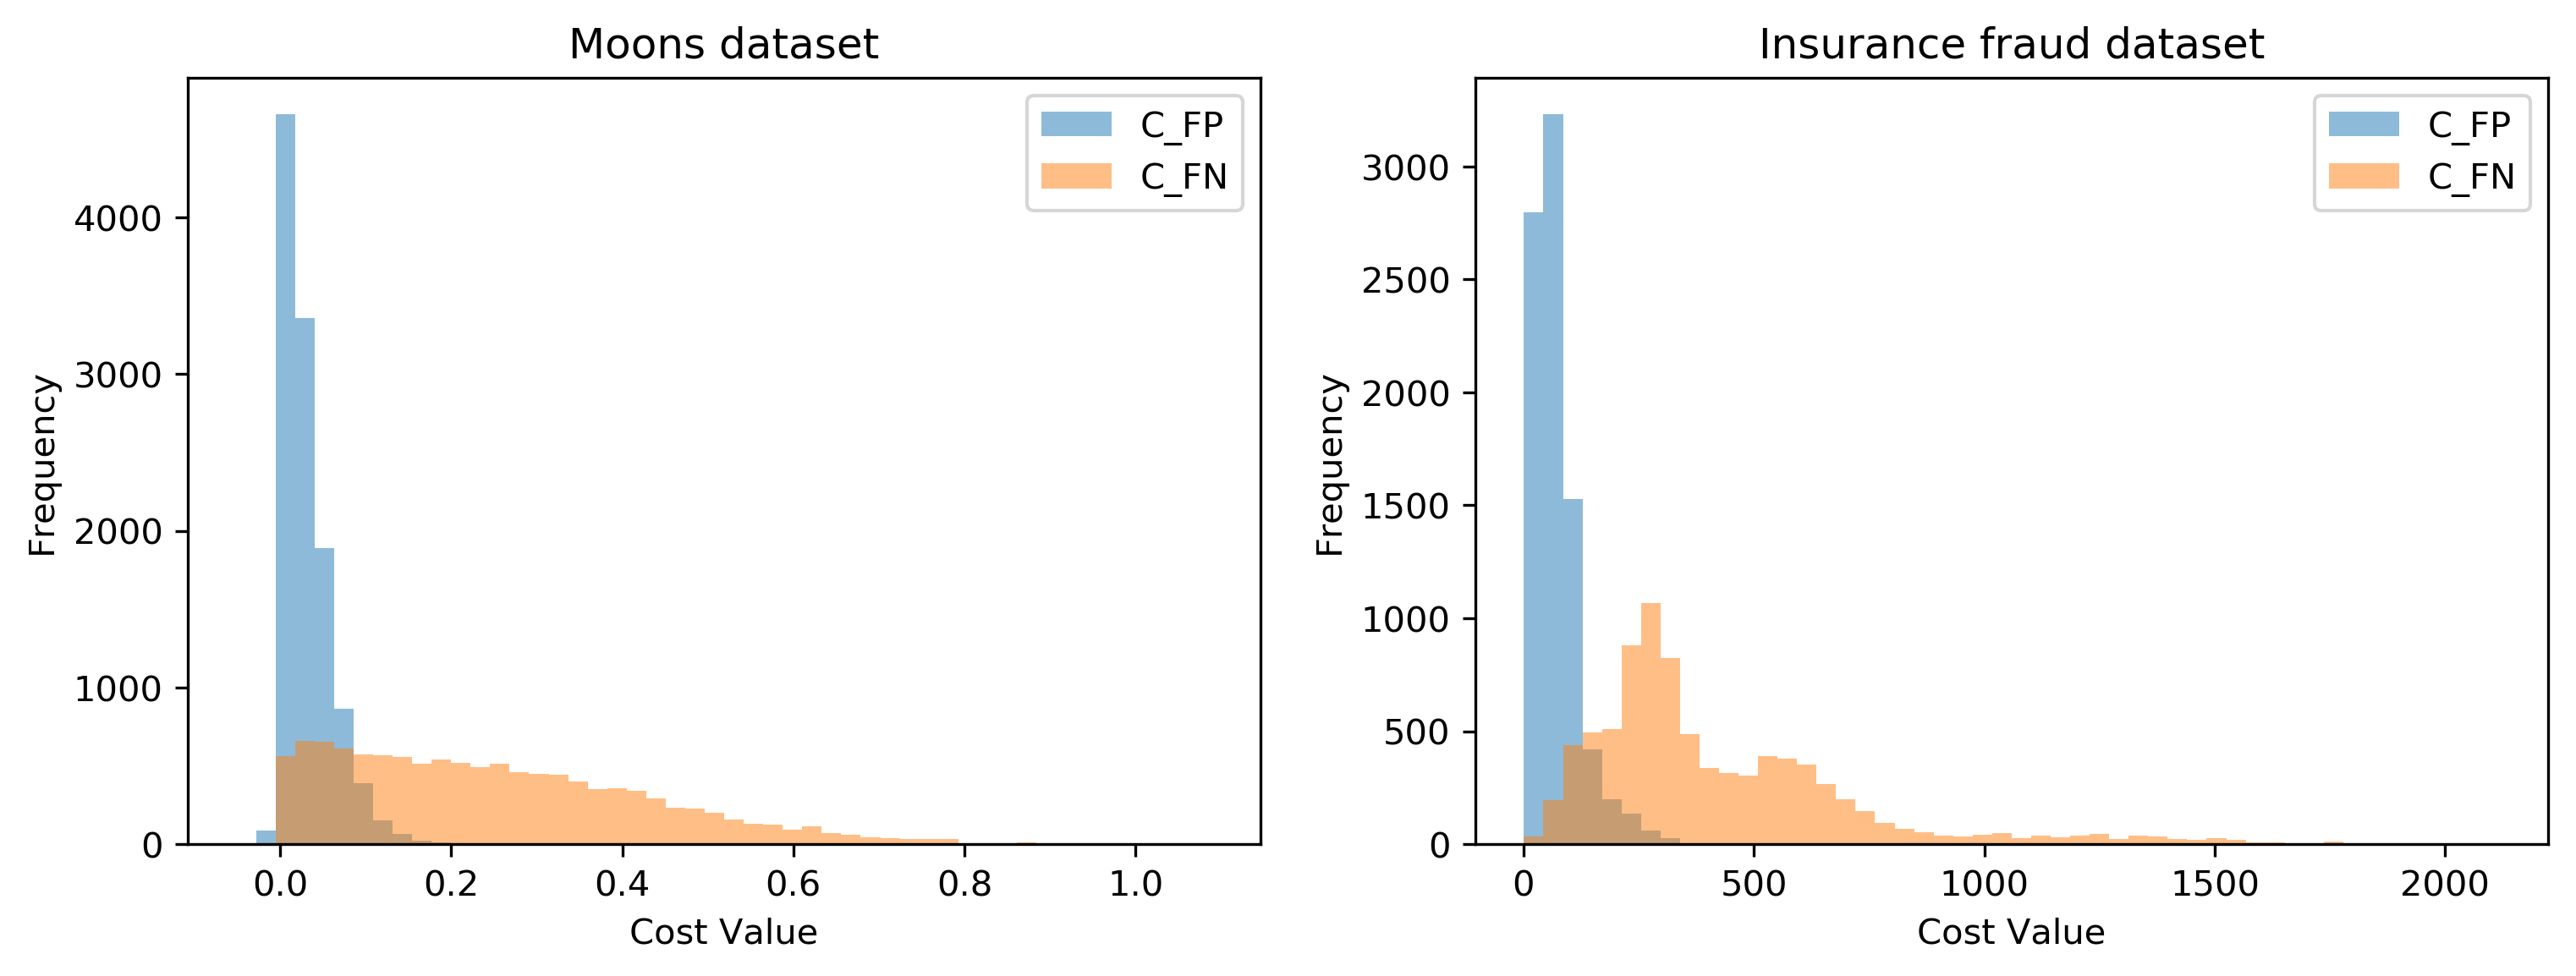

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4), dpi = 300)

s1 = pd.DataFrame({'C_FP' : toy_datasets[0]['cost_mat'][:,0], 'C_FN' : toy_datasets[0]['cost_mat'][:,1]})
s1.plot.hist(bins=50, alpha=0.5, ax = axes[0])
axes[0].set(xlabel = 'Cost Value', title = 'Moons dataset')

s2 = pd.DataFrame({'C_FP' : ins_datasets[0]['cost_mat'][:,0], 'C_FN' : ins_datasets[0]['cost_mat'][:,1]})
s2.plot.hist(bins=50, alpha=0.5, ax = axes[1])
axes[1].set(xlabel = 'Cost Value', title = 'Insurance fraud dataset')

plt.savefig('Fig3.png', dpi=300)

In [45]:
print(s1.skew())
print(s2.skew())

C_FP    1.439033
C_FN    0.759264
dtype: float64
C_FP    1.926143
C_FN    1.770213
dtype: float64


#### Ingosstrah dataset generator

In [19]:
ins_datasets = []

df = pd.read_csv('Ingosstrah/insclass_train.csv')
df.shape

(151406, 29)

In [20]:
df = df.drop(['variable_3','variable_7','variable_9','variable_15'],axis = 1) # useless features
df = df.dropna(axis = 0)
print(df.shape)

(118800, 25)


In [21]:
df_numeric = df.select_dtypes(exclude=['object'])
df_obj = df.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df = pd.concat([df_numeric, df_obj], axis=1)
print(df.shape)

(118800, 25)


In [22]:
df.target.value_counts()

0    109391
1      9409
Name: target, dtype: int64

In [23]:
X = df.drop(['target'], axis =1).values
y = df.target
print(X.shape, y.shape)

(118800, 24) (118800,)


In [24]:
C1 = df.variable_6 * (np.full(len(y), 3.0) + np.random.randn(len(y)) * np.ones(len(y))) - df.variable_4  / 100
C2 = df.variable_6 * (np.full(len(y),30.0) + np.random.randn(len(y)) * np.ones(len(y))) - df.variable_4  / 100

cost_mat = np.zeros((len(y),4))
cost_mat[:,0] =  [* map(lambda c1,c2: c1 if c1 < c2 else c2, C1,C2)] # FP
cost_mat[:,1] =  [* map(lambda c1,c2: c1 if c1 > c2 else c2, C1,C2)] # FN

In [25]:
cost_mat

array([[  506.12003306,  2910.16100628,     0.        ,     0.        ],
       [  387.16029607,  3359.15497847,     0.        ,     0.        ],
       [  137.2670457 ,  3680.23397509,     0.        ,     0.        ],
       ..., 
       [  323.76049877,  3486.05228861,     0.        ,     0.        ],
       [  183.8275516 ,  4867.47231201,     0.        ,     0.        ],
       [  365.91041365,  2658.72118773,     0.        ,     0.        ]])

In [26]:
# ins_datasets.append({'label' : 'ingos', 'X' : X, 'y' : y, 'cost_mat' : cost_mat})

#### Alpha Insurance Dataset generator

In [27]:
ai = pd.read_csv('../ML - AlphaInsurance/Data_AlfaInsurance_170918.csv', sep =';')
ai.dropna(inplace = True)
ai.shape

(8400, 32)

In [28]:
A = ['LADA','ВАЗ']
B = ['HYUNDAI','FORD','KIA','OPEL','RENAULT','DAEWOO','CHEVROLET']
C = ['TOYOTA','MAZDA','NISSAN','SUBARU','HONDA','MITSUBISHI','SUZUKI','VOLKSWAGEN']
D = ['AUDI','MERCEDES-BENZ']
E = ['PORSHE']

v_new = []
for v in ai.VEH_model:
    flag = 0
    for a in A:
        if a in v:
            v_new.append(5.0 +np.random.randn() * 1.0)
            flag = 1
    for b in B:
        if b in v:
            v_new.append(10.0 +np.random.randn() * 1.0)
            flag = 1
    for c in C:
        if c in v:
            v_new.append(20.0 +np.random.randn() * 3.0)
            flag = 1
    for d in D:
        if d in v:
            v_new.append(40.0 +np.random.randn() * 8.0)
            flag = 1
    for e in E:
        if e in v:
            v_new.append(100.0 +np.random.randn() * 20.0)
            flag = 1
    if flag < 1:
        v_new.append(10.0 +np.random.randn() * 2.0)

In [29]:
ai.VEH_model = v_new

In [30]:
cost_mat = np.zeros((len(ai),4))
cost_mat[:,0] = abs(ai.VEH_model - ai.VEH_age / 10) * (np.full(len(ai), 5.0) + np.random.randn(len(ai)) * np.full(len(ai), 1.0)) # FP
cost_mat[:,1] = abs(ai.VEH_model - ai.VEH_age / 10) * (np.full(len(ai),30.0) + np.random.randn(len(ai)) * np.full(len(ai), 4.0))# FN

In [31]:
cost_mat

array([[  59.67715181,  275.3949378 ,    0.        ,    0.        ],
       [  74.34092125,  287.15692886,    0.        ,    0.        ],
       [  34.97882032,  273.32239539,    0.        ,    0.        ],
       ..., 
       [  72.28841748,  520.59725804,    0.        ,    0.        ],
       [  55.9620507 ,  254.530545  ,    0.        ,    0.        ],
       [  42.51982321,  576.1616156 ,    0.        ,    0.        ]])

In [32]:
cost_mat[:,1] / cost_mat[:,0]

array([  4.61474667,   3.86270339,   7.81393978, ...,   7.20166904,
         4.54827051,  13.55042359])

In [33]:
ai_numeric = ai.select_dtypes(exclude=['object'])
ai_obj = ai.select_dtypes(include=['object']).copy()

for c in ai_obj:
    ai_obj[c] = pd.factorize(ai_obj[c])[0]

ai = pd.concat([ai_numeric, ai_obj], axis=1)
print(ai.shape)

(8400, 32)


In [34]:
X = ai.drop(['bad'], axis = 1).values
y = ai.bad
print(X.shape, y.shape)

(8400, 31) (8400,)


In [39]:
ai['C_FP'] = cost_mat[:,0]
ai['C_FN'] = cost_mat[:,1] 
ai['C_TP'] = cost_mat[:,2]
ai['C_TN'] = cost_mat[:,3]
ai['y'] = ai.bad
ai.drop(['bad'], axis =1, inplace = True)
ai.to_csv('alpha.csv')

In [35]:
ins_datasets.append({'label' : 'alpha', 'X' : X, 'y' : y, 'cost_mat' : cost_mat})

#### Toy datasets generator

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs

n_samples = 20000

ds_labels = ['circles','moons','blobs'] 

datagens = [make_circles(n_samples = n_samples, shuffle=True, noise=0.2, random_state=1, factor=0.5),
            make_moons(n_samples = n_samples, noise=0.3, random_state=1),
            make_blobs(n_samples = n_samples, n_features=2, centers=2, cluster_std=4.0, center_box=(-10.0, 10.0), shuffle=True, random_state=1)]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

toy_datasets = []

for i,ds in enumerate(datagens):
    X, y = ds

    pos_mask = y > 0
    neg_mask = np.logical_not(pos_mask)
    
    X_pos, y_pos = X[pos_mask], y[pos_mask]
    X_neg, y_neg = X[neg_mask], y[neg_mask]
    
    new_pos_mask = [True if x < 3 else False for x in np.random.randint(20, size=len(y_pos))]
    
    X_pos, y_pos = X_pos[new_pos_mask], y_pos[new_pos_mask]
    
    X = np.append(X_pos,X_neg,axis = 0)
    y = np.append(y_pos, y_neg, axis = 0)

    cost_matrix = np.zeros((len(y),4)) 
    cost_matrix[:,0] = (abs(X[:,0]) * abs(X[:,1])) * np.random.normal(0.1,0.05,size = len(y)) # FP
    cost_matrix[:,1] = (abs(X[:,0]) * abs(X[:,1])) * np.random.normal(0.8,0.05,size = len(y)) # FN 

    toy_datasets.append({'label' : ds_labels[i], 'X' : X, 'y' : y, 'cost_mat' : cost_matrix})

    print(X.shape,y.shape, len(y[y == 0]), len(y[y > 0]), len(y[y > 0]) / y.shape[0])
    print(asymmetry(y,cost_matrix))
    
    df = pd.DataFrame(X, columns = ['x1','x2'])
    df['y'] = y
    df.plot.scatter(x = 'x1', y='x2', c ='y', colormap='tab10', ax=axes[i])
    
for d, label in zip(toy_datasets,ds_labels):  
    df = pd.DataFrame(np.concatenate((np.concatenate((d['X'],np.array([d['y']]).T),axis = 1),d['cost_mat']) ,axis = 1), 
                      columns = ['x1','x2','y','C_FP', 'C_FN', 'C_TP', 'C_TN'])
    print(label, len(df), len(df[df.y > 0]), len(df[df.y > 0]) / len(df) )
    df.to_csv(label+'.csv')